<a href="https://colab.research.google.com/github/Linkanblomman/LSTM_occupancy_detection/blob/main/Occupancy_detection_dataset_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

from tqdm.auto import tqdm

import time

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [ ]:
print(torch.__version__)

1.7.0+cu101


Customize the plot

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

Device configuration

In [ ]:
seed_value = 42
torch.manual_seed(seed_value)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla V100-SXM2-16GB


Load Occupancy Detection Dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
!unzip occupancy_data.zip
!rm occupancy_data.zip

In [ ]:
!ls

datatest2.txt  datatest.txt  datatraining.txt  sample_data


In [ ]:
raw_data_training_file = './datatraining.txt'

raw_data_test_file = './datatest.txt'
raw_data_test2_file = './datatest2.txt'

In [ ]:
training_occupancy_dataframe = pd.read_csv(raw_data_training_file)

test_occupancy_dataframe = pd.read_csv(raw_data_test_file)
test2_occupancy_dataframe = pd.read_csv(raw_data_test2_file)

training_occupancy_df = pd.concat([training_occupancy_dataframe, test2_occupancy_dataframe], ignore_index=True) # Concat dataframe so that model won't overfit

In [ ]:
def plot_signal(ax, x, y, title):
    ax.plot(x, y)
    if(title == "Temperature"):
      ax.set_title("Temperature")
      ax.set_ylabel("Temperature (°C)")
    elif(title == "Humidity"):
      ax.set_title("Humidity")
      ax.set_ylabel("Humidity (%)")
    elif(title == "Occupancy"):
      ax.set_title("Occupancy")
      ax.set_ylabel("Occupancy (0, 1)")
    elif(title == "LSTM"):
      ax.set_title("LSTM model prediction on test dataset")
      ax.set_ylabel("Occupancy (0, 1)")
    
    ax.set_xlabel("Observation")
    ax.set_xlim([min(x) , max(x)])

    start, end = ax.get_xlim()
    stepsize = 600
    ax.xaxis.set_ticks(np.arange(start, end + stepsize, stepsize))
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

In [ ]:
def plt_dataFrame(dataFrame, features):
  subset_features = dataFrame[features]

  fig, axs = plt.subplots(nrows = len(subset_features.columns.values), figsize=(18, 18))
  for i in range(0, len(subset_features.columns.values)):
      plot_signal(axs[i], dataFrame.index, subset_features[subset_features.columns.values[i]],subset_features.columns.values[i])
  plt.subplots_adjust(hspace=0.5)
  plt.show()

In [ ]:
features = ["Temperature", "Humidity", "Occupancy"]

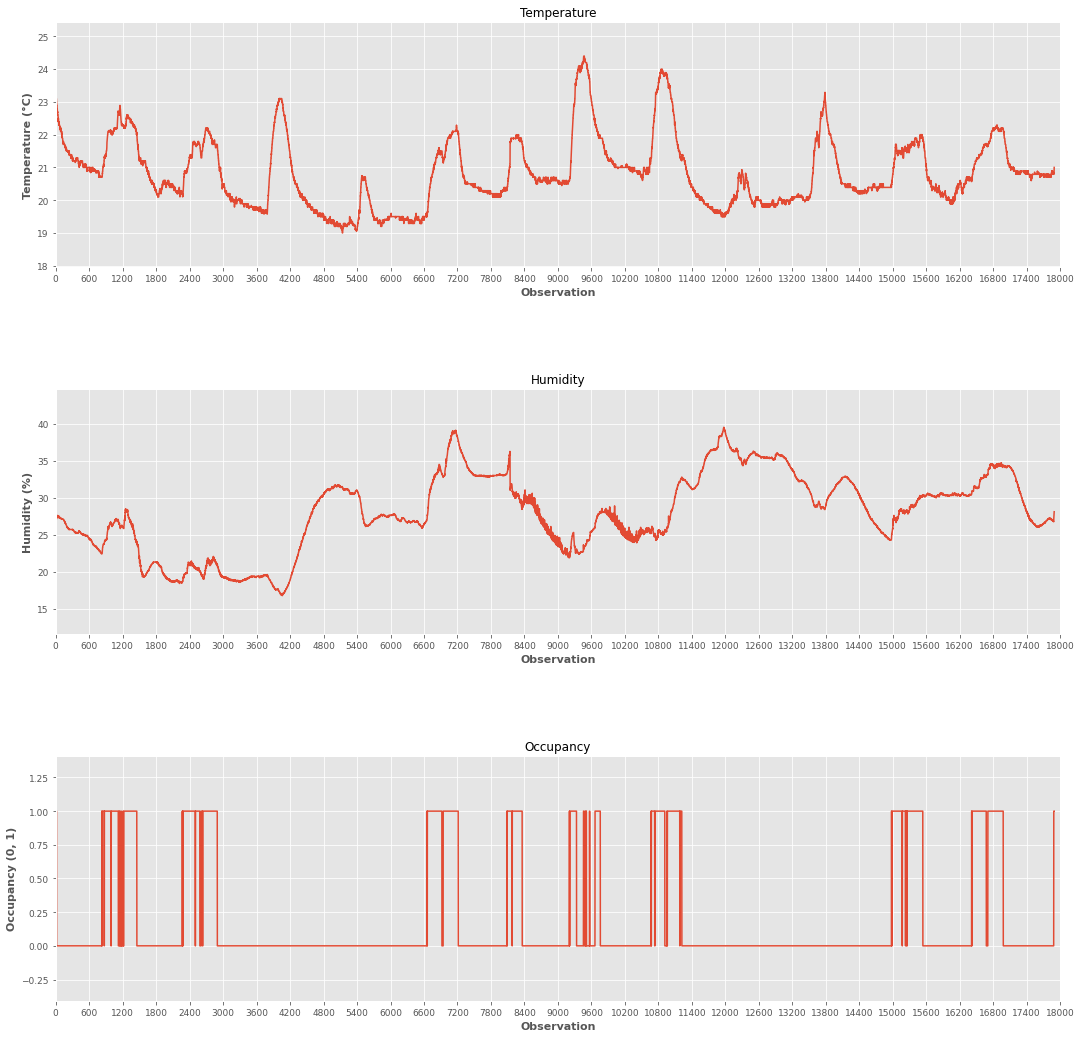

In [ ]:
plt_dataFrame(training_occupancy_df, features)

In [ ]:
def splitToFeaturesAndLabels(df, dataset):
  features = np.array(df[['Temperature', 'Humidity']])
  labels = np.array(df['Occupancy'].values)

  print(f"Total {dataset}_features for each feature: {len(features)}")
  print(f"Total {dataset}_labels: {len(labels)}")

  return features, labels

In [ ]:
dataset_features, dataset_labels = splitToFeaturesAndLabels(training_occupancy_df, "dataset")
print("\n")
test_features, test_labels = splitToFeaturesAndLabels(test_occupancy_dataframe, "test")

Total dataset_features for each feature: 17895
Total dataset_labels: 17895


Total test_features for each feature: 2665
Total test_labels: 2665


In [ ]:
scaler = StandardScaler() 
dataset_features = scaler.fit_transform(dataset_features)
test_features = scaler.fit_transform(test_features)

In [ ]:
num_classes = 2 # Occupancy (0, 1)
batch_size = 32
learning_rate = 0.001

timestep = 20 # minutes

input_size = 2
hidden_size = 40 # hidden layers
num_layers = 1

validation_size = 0.10 # Validation dataset size

Set timestep. Credit to Sam Leach [link](https://github.com/samuelleach/lstm-sequence-to-label)

In [ ]:
def timeSteps(X, Y, **options):   
    timestep = options.pop('timestep', None)
    _X, _Y = [], []
    for index in range(len(X) - timestep - 1):
      a = X[index:(index+timestep)]
      _X.append(a)
      _Y.append(Y[index + timestep])

    return np.array(_X), np.array(_Y)

In [ ]:
X_train, Y_train = timeSteps(dataset_features, dataset_labels, timestep=timestep)
X_test, Y_test = timeSteps(test_features, test_labels, timestep=timestep)

Split dataset into training and validation datasets

In [ ]:
(X_train, X_validation, Y_train, Y_validation) = train_test_split(X_train, Y_train, test_size=validation_size, random_state=seed_value, shuffle=False)

In [ ]:
print(f"Training dataset size: {len(X_train)}")
print(f"Validation dataset size: {len(X_validation)}")

Training dataset size: 16086
Validation dataset size: 1788


PyTorch Dataset and DataLoader

In [ ]:
class ToTensor:
  def __call__(self, batch):
    inputs, targets = batch
    return torch.tensor(inputs, dtype=torch.float).to(device), torch.tensor(targets, dtype=torch.int).to(device)

In [ ]:
class OccDecDataset(Dataset):

  def __init__(self, x_features, y_features, transform=None):
    # Data loading
    self.x = x_features
    self.y = y_features
    self.n_samples = x_features.shape[0]
    self.transform = transform

  def __getitem__(self, index):
    batch = self.x[index], self.y[index] # [x , y]

    if self.transform:
      batch = self.transform(batch)
    else:
      print("Use transform ToTensor")

    return batch

  def __len__(self):
    # len(dataset)
    return self.n_samples

In [ ]:
train_dataset = OccDecDataset(x_features=X_train, y_features=Y_train, transform=ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

validation_dataset = OccDecDataset(x_features=X_validation, y_features=Y_validation, transform=ToTensor())
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = OccDecDataset(x_features=X_test, y_features=Y_test, transform=ToTensor())
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

LSTM model architecture

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_layer_size, num_classes): # num_classes == output_size
    super(RNN, self).__init__()
    self.hidden_layer_size = hidden_layer_size
    self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) # input_seq has to be -> (batch_size, seq_length, input_size)
    self.fc = nn.Linear(hidden_layer_size, num_classes)

  def forward(self, input_seq):
    # Set initial hidden states and cell states
    h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)
    c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(device)

    # "out" will give you access to all hidden states in the sequence
    # "hidden" will allow you to continue the sequence and backpropagate, by passing it as an argument to the lstm at a later time
    out, (h_out, _) = self.lstm(input_seq, (h0,c0)) # output of shape (seq_len, batch, num_directions * hidden_size)

    # flatten LSTM input for fully connected layer: (batch_size, hidden_size)
    h_out = h_out.view(-1, self.hidden_layer_size)
    out = self.fc(h_out)

    return out

In [ ]:
model = RNN(input_size, hidden_size, num_classes).to(device)
model.to(device)
print(model)

RNN(
  (lstm): LSTM(2, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=2, bias=True)
)


Loss (CrossEntropyLoss) and optimizer (Adam optimization algorithm)

In [ ]:
criterion = nn.CrossEntropyLoss() # Includes SoftMax and the prediction later will have raw values
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

Train the model

In [ ]:
def fit(model, train_dataloader):
  print('Training')
  model.train()
  train_running_loss = 0.0
  train_running_correct = 0

  for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)): 
    features, labels = data[0].to(device), data[1].to(device)  

    labels = labels.type(torch.int64)
    features = features.to(device)
    
    optimizer.zero_grad()
    outputs = model(features) # input of shape (seq_len, batch, input_size)

    loss = criterion(outputs, labels)
    train_running_loss += loss.item()

    _, preds = torch.max(input=outputs.data, dim=1)
    train_running_correct += (preds == labels).sum().item()

    loss.backward()
    optimizer.step()
 
  train_loss = train_running_loss/len(train_dataloader.dataset)
  train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
  
  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
  
  return train_loss, train_accuracy

Validate the model

In [ ]:
def validate(model, validation_dataloader):
  print('Validating')
  model.eval()
  val_running_loss = 0.0
  val_running_correct = 0 
  with torch.no_grad():
    for i, data in tqdm(enumerate(validation_dataloader), total=int(len(validation_dataset)/validation_dataloader.batch_size)): 

      features, labels = data[0].to(device), data[1].to(device) 
      labels = labels.type(torch.int64)
      
      outputs = model(features)

      loss = criterion(outputs, labels)
      val_running_loss += loss.item()
      _, preds = torch.max(input=outputs.data, dim=1)
      val_running_correct += (preds == labels).sum().item()
      
    val_loss = val_running_loss/len(validation_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(validation_dataloader.dataset)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

  return val_loss, val_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

epochs = 15
start = time.time()

for epoch in range(epochs):
  print(f"Epoch {epoch+1} of {epochs}")
  train_epoch_loss, train_epoch_accuracy = fit(model, train_dataloader)
  val_epoch_loss, val_epoch_accuracy = validate(model, validation_dataloader)


  train_loss.append(train_epoch_loss)
  train_accuracy.append(train_epoch_accuracy)
  val_loss.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

end = time.time()

print(f"{(end-start)/60:.2f} minutes")

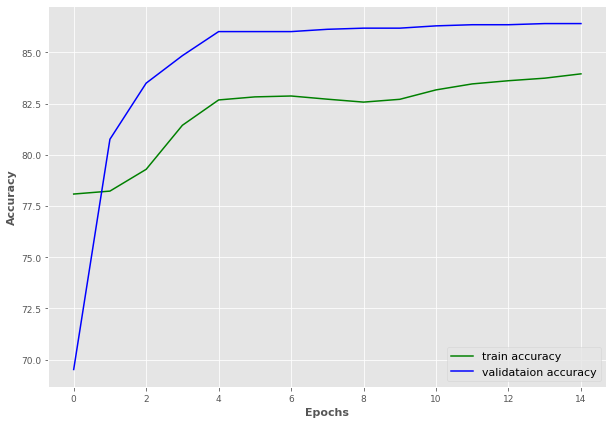

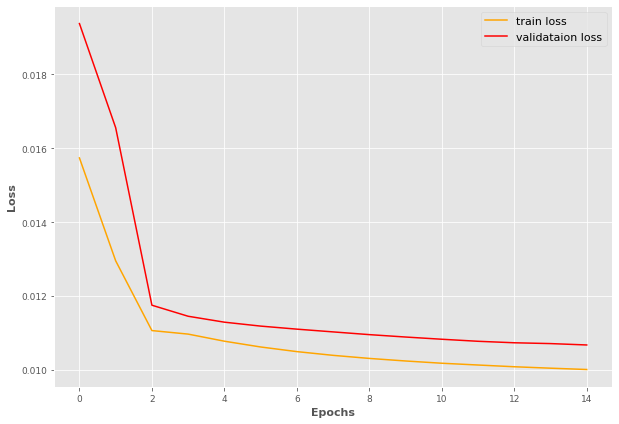

In [ ]:
# Accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test the model

In [ ]:
def evaluate(dataloader, dataset_size):
  pred_plt = []
  batch_size = 1

  model.eval()
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset_size))):
      features, labels = data[0].to(device), data[1].to(device) 
      labels = labels.type(torch.int64).to(device)

      outputs = model(features)

      _, preds = torch.max(input=outputs.data, dim=1) # max returns (value ,index)
      pred_plt.append(preds.item())
      n_samples += labels.size(0)
      n_correct += (preds == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy on the Occupancy detection test dataset: {acc} %')

    return pred_plt

In [ ]:
preds_test_plt = evaluate(test_dataloader, test_dataset)


Accuracy on the Occupancy detection test dataset: 84.49319213313161 %


In [ ]:
series_preds_test = np.hstack((np.zeros(timestep + 1, dtype=int), preds_test_plt))

In [ ]:
test_occupancy_dataframe['LSTM'] = pd.Series(series_preds_test, index=test_occupancy_dataframe.index)

In [ ]:
features = ['Temperature','Humidity', 'Occupancy','LSTM']

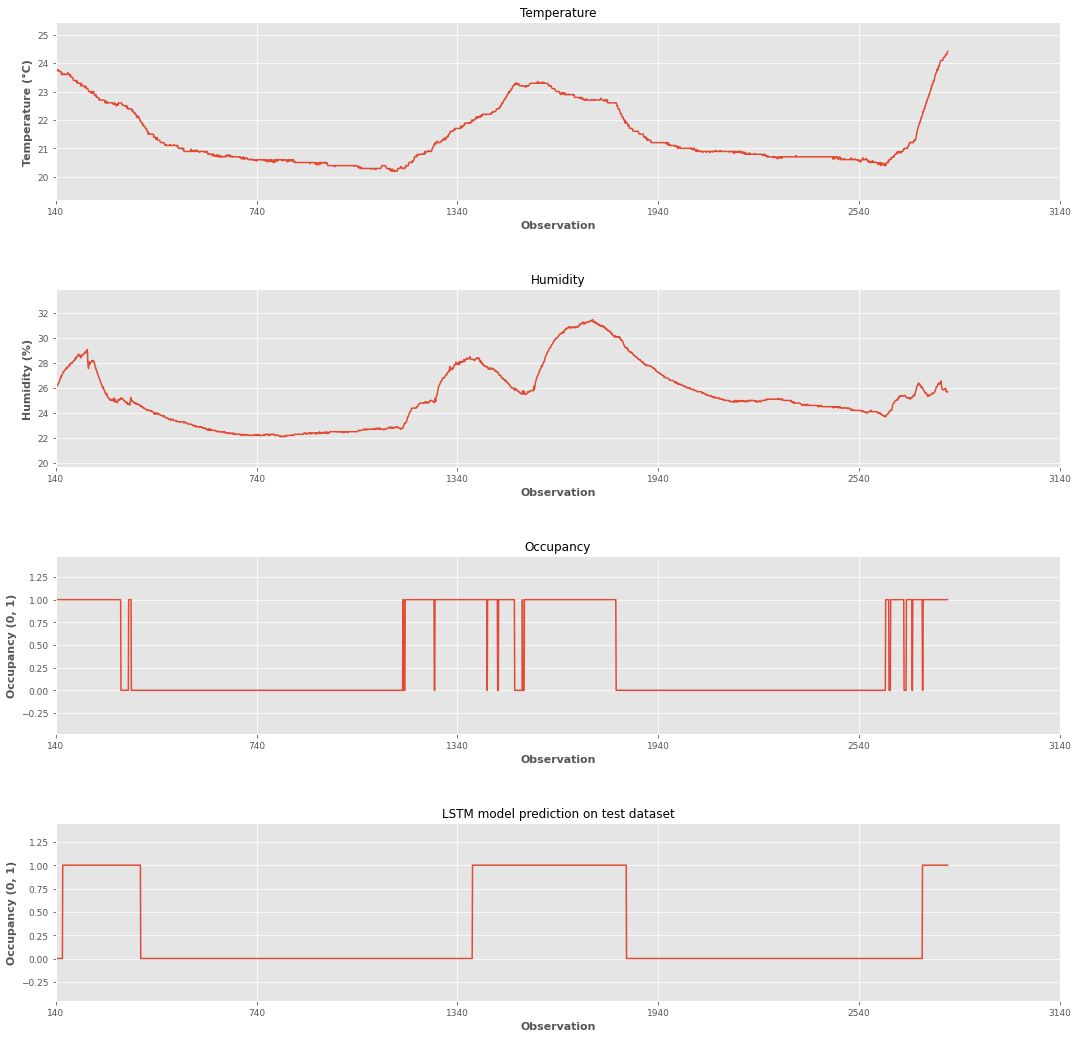

In [ ]:
plt_dataFrame(test_occupancy_dataframe, features)

In [ ]:
torch.save(model.state_dict(), "LSTM_model.pth") # Save model